# Bayesian Optimization

First attempt using Bayesian optimization for OAR dose and volume parameters. Using grid search data from RayStation with 40 maximum iterations and conversion after 20 iterations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from skopt import gp_minimize
from skopt.callbacks import DeltaXStopper

In [2]:
def plot_oar_grid(results):
    plt.imshow(results, origin='lower')
    plt.xlabel('OAR Volume Parameter')
    plt.ylabel('OAR Dose Parameter')
    plt.axis('auto')
    plt.colorbar(label='OAR Average Dose')

## Load and plot grid search results

In [3]:
# Load grid search results
oar_avg = np.load('grid_search_40/oar_avg.npy')
ptv_d95 = np.load('grid_search_40/ptv_d95.npy')
oar_avg_norm = np.load('grid_search_40/oar_avg_norm.npy')
ptv_d95_norm = np.load('grid_search_40/ptv_d95_norm.npy')

In [4]:
# Get rid of zero dose values
oar_avg = oar_avg[1:, :]
ptv_d95 = ptv_d95[1:, :]
oar_avg_norm = oar_avg_norm[1:, :]
ptv_d95_norm = ptv_d95_norm[1:, :]

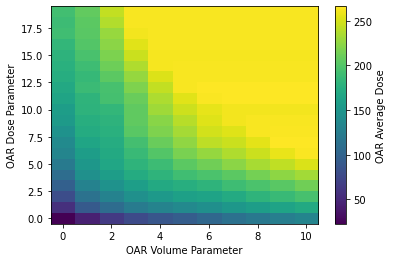

In [5]:
# Raw data
plot_oar_grid(oar_avg)

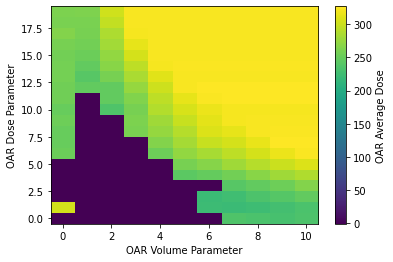

In [6]:
# Normalized data
plot_oar_grid(oar_avg_norm)

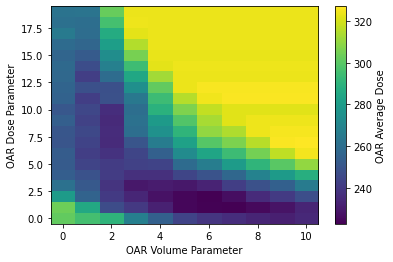

In [7]:
# Normalized data with estimated values
idx = oar_avg_norm == -1
oar_avg_est = oar_avg_norm.copy()
oar_avg_est[idx] = 4800*oar_avg[idx]/ptv_d95[idx]
plot_oar_grid(oar_avg_est)

## Interpolate OAR average dose

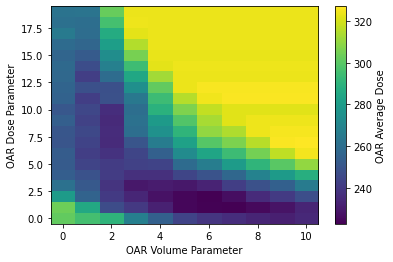

In [8]:
# Make sure same input produces same output
volumes = np.arange(0, 11)
doses = np.arange(100, 2001, 100)
oar_avg_func = interpolate.interp2d(volumes, doses, oar_avg_est)
plot_oar_grid(oar_avg_func(volumes, doses))

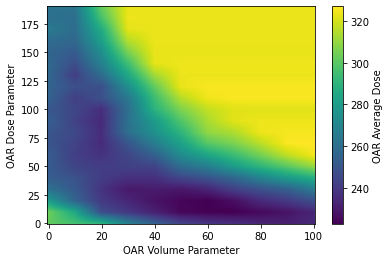

In [9]:
# Now let's look at a finer grid
plot_oar_grid(oar_avg_func(np.arange(0, 10.1, 0.1), np.arange(100, 2001, 10)))

In [10]:
# For gp_minimize, input needs to be a single vector, output needs to be scalar
def oar_avg_func2(pars):
    return oar_avg_func(pars[0], pars[1])[0]

## Bayesian optimization

Find dose and volume parameters that give lowest OAR dose.

* Tutorial: http://krasserm.github.io/2018/03/21/bayesian-optimization/
* Documentation: https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize

/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


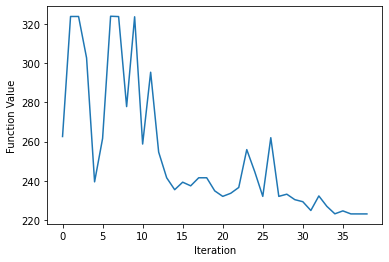

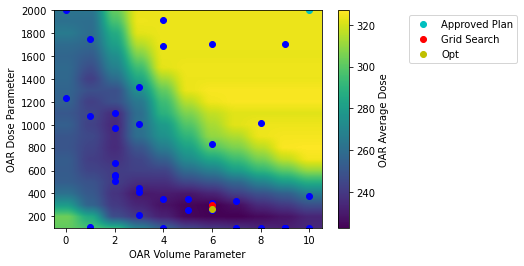

In [18]:
# Optimize
r = gp_minimize(oar_avg_func2, dimensions=[(0, 10), (100, 2000)],
                x0=[0, 2000], y0=oar_avg_func2([0, 2000]),
                random_state=0, callback=DeltaXStopper(1))
v_vals = [r.x_iters[ii][0] for ii in range(len(r.x_iters))]
d_vals = [r.x_iters[ii][1]-100 for ii in range(len(r.x_iters))]

# Plot convergence
plt.plot(r.func_vals)
plt.xlabel('Iteration')
plt.ylabel('Function Value')

# Plot iterates
fig, ax = plt.subplots()
im = ax.imshow(oar_avg_func(np.arange(0, 11), np.arange(100, 2001)), origin='lower')
ax.plot(10, 1900, 'co')
ax.plot(6, 200, 'ro', zorder=3)
ax.plot(v_vals[-1], d_vals[-1], 'yo', zorder=3)
ax.plot(v_vals, d_vals, 'bo')
ax.set_xlabel('OAR Volume Parameter')
ax.set_yticks(np.arange(100, 2001, 200))
ax.set_yticklabels(np.arange(200, 2001, 200))
ax.set_ylabel('OAR Dose Parameter')
ax.axis('auto')
ax.legend(bbox_to_anchor=(1.75, 1), labels=['Approved Plan', 'Grid Search', 'Opt'])
plt.colorbar(im, label='OAR Average Dose')

* Looks pretty good for this toy problem!
* There are lots of other parameters for gp_minimize that I can explore, including one that controls noise. I think we can assume that our function is not noisy, since it's coming directly from RayStation. However, if I use early stopping, maybe we could consider the results as noisy.
* Would be interesting to plot the surrogate function for various iterations...

## What about missing values?

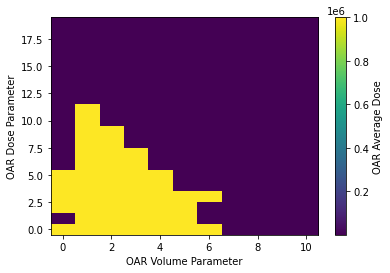

In [12]:
# Make missing values high rather than -1
oar_avg_norm2 = oar_avg_norm.copy()
oar_avg_norm2[oar_avg_norm == -1] = 1e6
plot_oar_grid(oar_avg_norm2)

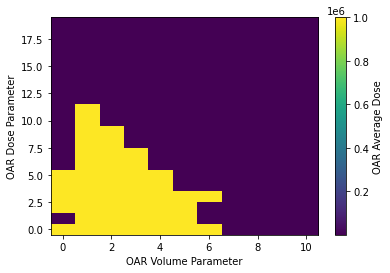

In [13]:
# Make sure same input produces same output
volumes = np.arange(0, 11)
doses = np.arange(100, 2001, 100)
oar_avg_func3 = interpolate.interp2d(volumes, doses, oar_avg_norm2)
plot_oar_grid(oar_avg_func3(volumes, doses))

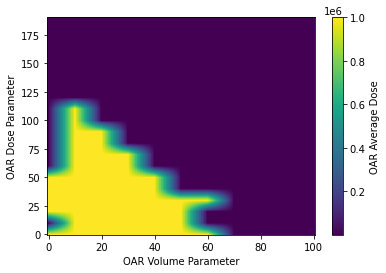

In [14]:
# Now let's look at a finer grid
plot_oar_grid(oar_avg_func3(np.arange(0, 10.1, 0.1), np.arange(100, 2001, 10)))

In [15]:
# For gp_minimize, input needs to be a single vector, output needs to be scalar
def oar_avg_func4(pars):
    return oar_avg_func3(pars[0], pars[1])[0]

/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


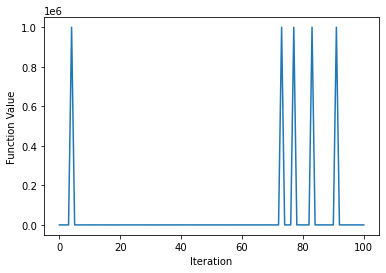

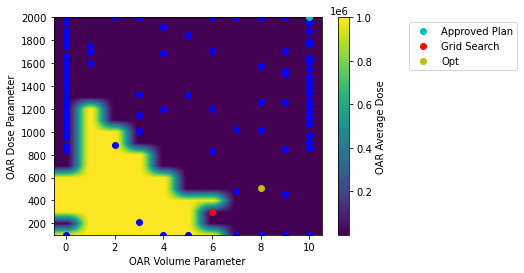

In [16]:
# Optimize
r = gp_minimize(oar_avg_func4, dimensions=[(0, 10), (100, 2000)],
                x0=[0, 2000], y0=oar_avg_func4([0, 2000]),
                random_state=0, callback=DeltaXStopper(1))
v_vals = [r.x_iters[ii][0] for ii in range(len(r.x_iters))]
d_vals = [r.x_iters[ii][1]-100 for ii in range(len(r.x_iters))]

# Plot convergence
plt.plot(r.func_vals)
plt.xlabel('Iteration')
plt.ylabel('Function Value')

# Plot iterates
fig, ax = plt.subplots()
im = ax.imshow(oar_avg_func3(np.arange(0, 11), np.arange(100, 2001)), origin='lower')
ax.plot(10, 1900, 'co', zorder=3)
ax.plot(6, 200, 'ro', zorder=3)
ax.plot(v_vals[-1], d_vals[-1], 'yo', zorder=3)
ax.plot(v_vals, d_vals, 'bo')
ax.set_xlabel('OAR Volume Parameter')
ax.set_yticks(np.arange(100, 2001, 200))
ax.set_yticklabels(np.arange(200, 2001, 200))
ax.set_ylabel('OAR Dose Parameter')
ax.axis('auto')
ax.legend(bbox_to_anchor=(1.75, 1), labels=['Approved Plan', 'Grid Search', 'Opt'])
plt.colorbar(im, label='OAR Average Dose')

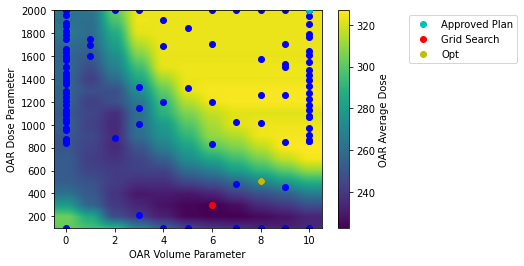

In [17]:
# Plot iterates
fig, ax = plt.subplots()
im = ax.imshow(oar_avg_func(np.arange(0, 11), np.arange(100, 2001)), origin='lower')
ax.plot(10, 1900, 'co', zorder=3)
ax.plot(6, 200, 'ro', zorder=3)
ax.plot(v_vals[-1], d_vals[-1], 'yo', zorder=3)
ax.plot(v_vals, d_vals, 'bo')
ax.set_xlabel('OAR Volume Parameter')
ax.set_yticks(np.arange(100, 2001, 200))
ax.set_yticklabels(np.arange(200, 2001, 200))
ax.set_ylabel('OAR Dose Parameter')
ax.axis('auto')
ax.legend(bbox_to_anchor=(1.75, 1), labels=['Approved Plan', 'Grid Search', 'Opt'])
plt.colorbar(im, label='OAR Average Dose')

Definitely performs worse when we use large values for points that can't be normalized. Maybe a combination of the non-smoothness of the function space, the smoothness assumed in the surrogate function (?), and the large difference in values between these regions. Maybe for now just work with the estimated values, and in RayStation we could even cut down on time by only doing 10 or 20 iterations rather than 40. Then the final plan would use the larger number of iterations.